In [1]:
pip install mlflow faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, ndcg_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import kagglehub
import zipfile
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Download and extract the Amazon Reviews dataset
def download_and_extract_dataset():
    print("Downloading Amazon Reviews dataset...")
    path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
    print(f"Dataset downloaded to: {path}")

    # Find and extract zip files if needed
    zip_files = [f for f in os.listdir(path) if f.endswith('.zip')]

    if zip_files:
        for zip_file in zip_files:
            zip_path = os.path.join(path, zip_file)
            with zipfile.ZipFile(zip_path, 'r') as z:
                print(f"Extracting {zip_file}...")
                z.extractall(path)

    return path



In [ ]:
import os
import json
import logging
import random
from typing import Tuple, Optional

import numpy as np
import pandas as pd
from faker import Faker
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


def load_data(
    dataset_path: str,
    n_users: int = 1000,
    fake_seed: int = 42,
    text_feat_max: int = 100,
    text_svd_components: int = 20,
    max_reviews: int = 100000
) -> Tuple[pd.DataFrame, dict, dict, Optional[np.ndarray]]:
    """
    Load Amazon reviews (JSON or CSV), fake user IDs up front to avoid warnings,
    add extra features, and extract optional TF-IDF + SVD text features.

    Returns:
      df: DataFrame with columns ['user_id','item_id','rating','text_length','title_length',...]
      user_id_map: original user_id → index
      item_id_map: original item_id → index
      text_features: array of shape (n_samples, text_svd_components) or None
    """
    # 1) Load raw data
    json_files = [f for f in os.listdir(dataset_path) if f.endswith('.json')]
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

    if json_files:
        file_path = os.path.join(dataset_path, json_files[0])
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= max_reviews:
                    break
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
        df = pd.DataFrame(data)
    elif csv_files:
        file_path = os.path.join(dataset_path, csv_files[0])
        df = pd.read_csv(file_path, nrows=max_reviews)
    else:
        raise FileNotFoundError("No JSON or CSV files found in the dataset path")

    # 2) Immediately generate fake user_ids to ensure 'user_id' column exists
    Faker.seed(fake_seed)
    fake = Faker()
    unique_fake_ids = [fake.uuid4() for _ in range(n_users)]
    df['user_id'] = [random.choice(unique_fake_ids) for _ in range(len(df))]
    logging.info(f"Pre-assigned {n_users} fake users across {len(df)} records; 'user_id' column now present.")

    # 3) Identify core columns (now 'user_id' is guaranteed)
    user_col = 'user_id'
    # item detection
    if 'asin' in df.columns:
        item_col = 'asin'
    elif 'product_id' in df.columns:
        item_col = 'product_id'
    else:
        item_col = df.columns[1]
    # rating detection
    if 'overall' in df.columns:
        rating_col = 'overall'
    elif 'rating' in df.columns:
        rating_col = 'rating'
    else:
        rating_col = None
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]) and df[col].min() >= 0 and df[col].max() <= 5:
                rating_col = col
                break
    # text & title
    text_col = 'reviewText' if 'reviewText' in df.columns else 'text' if 'text' in df.columns else None
    title_col = 'summary' if 'summary' in df.columns else 'title' if 'title' in df.columns else None

    # 4) Keep and rename necessary columns
    cols = [c for c in [user_col, item_col, rating_col, text_col, title_col] if c]
    df = df[cols].copy()
    mapping = {user_col: 'user_id', item_col: 'item_id'}
    if rating_col:
        mapping[rating_col] = 'rating'
    df.rename(columns=mapping, inplace=True)

    # 5) Drop missing critical values
    df.dropna(subset=['user_id', 'item_id'], inplace=True)
    if 'rating' in df.columns:
        df.dropna(subset=['rating'], inplace=True)
        df['rating'] = df['rating'].astype(float)

    # 6) Add extra numeric features
    if text_col:
        df['text_length'] = df[text_col].fillna('').astype(str).apply(len)
    if title_col:
        df['title_length'] = df[title_col].fillna('').astype(str).apply(len)

    # 7) Create index maps
    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()
    user_id_map = {u: i for i, u in enumerate(user_ids)}
    item_id_map = {v: j for j, v in enumerate(item_ids)}
    df['user_idx'] = df['user_id'].map(user_id_map)
    df['item_idx'] = df['item_id'].map(item_id_map)

    # 8) Extract text features if possible
    text_features = None
    if text_col:
        vec = TfidfVectorizer(max_features=text_feat_max, stop_words='english')
        sample = df[text_col].fillna('').astype(str)
        tfidf = vec.fit_transform(sample)
        svd = TruncatedSVD(n_components=text_svd_components, random_state=fake_seed)
        text_features = svd.fit_transform(tfidf)
        logging.info(f"Extracted text_features shape={text_features.shape}")

    return df, user_id_map, item_id_map, text_features


In [ ]:
# Create cold start scenario
def create_cold_start_scenario(df, cold_start_ratio=0.2):
    """
    Create a cold start scenario by hiding interactions for some users
    """
    # Identify users with few interactions (naturally cold)
    user_counts = df['user_idx'].value_counts()

    # Find users with at least 5 interactions
    qualified_users = user_counts[user_counts >= 5].index.tolist()

    if len(qualified_users) == 0:
        print("Warning: No users with enough interactions for cold start simulation")
        # Fall back to random selection
        all_users = df['user_idx'].unique()
        cold_users = np.random.choice(
            all_users,
            size=int(len(all_users) * cold_start_ratio),
            replace=False
        )
    else:
        # Select a subset of users to simulate as cold start
        cold_users = np.random.choice(
            qualified_users,
            size=int(len(qualified_users) * cold_start_ratio),
            replace=False
        )

    print(f"Selected {len(cold_users)} users as cold start users")

    # For cold start users, keep only 1-2 interactions as "observed" and move the rest to "test"
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for user_idx in df['user_idx'].unique():
        user_data = df[df['user_idx'] == user_idx].copy()

        if user_idx in cold_users:
            # For cold users, keep only 1-2 interactions as observed
            n_observed = min(2, len(user_data))
            observed = user_data.sample(n_observed)
            holdout = user_data.drop(observed.index)

            train_df = pd.concat([train_df, observed])
            test_df = pd.concat([test_df, holdout])
        else:
            # For warm users, use 80/20 split
            user_train, user_test = train_test_split(user_data, test_size=0.2, random_state=42)
            train_df = pd.concat([train_df, user_train])
            test_df = pd.concat([test_df, user_test])

    print(f"Train set: {len(train_df)} interactions")
    print(f"Test set: {len(test_df)} interactions")

    # Create a mask to identify cold users
    cold_user_mask = np.isin(df['user_idx'].unique(), cold_users)

    return train_df, test_df, cold_user_mask, cold_users



In [ ]:
# Matrix Factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super(MatrixFactorization, self).__init__()
        # User and item embedding matrices
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

        # Initialize weights
        self.user_factors.weight.data.normal_(0, 0.1)
        self.item_factors.weight.data.normal_(0, 0.1)

    def forward(self, user_indices, item_indices):
        # Lookup embeddings
        user_embedding = self.user_factors(user_indices)
        item_embedding = self.item_factors(item_indices)

        # Element-wise product and sum
        prediction = (user_embedding * item_embedding).sum(dim=1)
        return prediction



In [ ]:
# Self-Paced Matrix Factorization
class SelfPacedMatrixFactorization:
    def __init__(self, n_users, n_items, n_factors=20,
                 lambda_start=0.1, lambda_end=10.0, lambda_steps=5,
                 learning_rate=0.01, weight_decay=0.001, batch_size=256,
                 device='cpu'):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lambda_start = lambda_start
        self.lambda_end = lambda_end
        self.lambda_steps = lambda_steps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.device = device

        # Create MF model
        self.model = MatrixFactorization(n_users, n_items, n_factors).to(device)
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        self.loss_fn = nn.MSELoss(reduction='none')  # Need sample-wise loss for self-paced learning

        # Lambda schedule (pace parameter)
        self.lambda_schedule = np.logspace(
            np.log10(lambda_start),
            np.log10(lambda_end),
            lambda_steps
        )

        # Track loss history
        self.train_losses = []
        self.val_losses = []

    def fit(self, train_df, val_df=None, epochs=10, verbose=True):
        """
        Train the model using self-paced learning
        """
        # Convert dataframes to tensors
        train_users = torch.LongTensor(train_df['user_idx'].values).to(self.device)
        train_items = torch.LongTensor(train_df['item_idx'].values).to(self.device)
        train_ratings = torch.FloatTensor(train_df['rating'].values).to(self.device)

        if val_df is not None:
            val_users = torch.LongTensor(val_df['user_idx'].values).to(self.device)
            val_items = torch.LongTensor(val_df['item_idx'].values).to(self.device)
            val_ratings = torch.FloatTensor(val_df['rating'].values).to(self.device)

        n_samples = len(train_df)
        n_batches = (n_samples + self.batch_size - 1) // self.batch_size

        # Initial weights (all samples equally weighted)
        sample_weights = torch.ones(n_samples, device=self.device)

        # Training loop
        for lambda_pace in self.lambda_schedule:
            if verbose:
                print(f"\nTraining with pace parameter λ={lambda_pace:.4f}")

            for epoch in range(epochs):
                # Shuffle data
                indices = torch.randperm(n_samples)
                train_users_shuffled = train_users[indices]
                train_items_shuffled = train_items[indices]
                train_ratings_shuffled = train_ratings[indices]
                sample_weights_shuffled = sample_weights[indices]

                # Training
                self.model.train()
                epoch_loss = 0.0

                for batch in range(n_batches):
                    start_idx = batch * self.batch_size
                    end_idx = min((batch + 1) * self.batch_size, n_samples)

                    if end_idx <= start_idx:
                        continue

                    batch_users = train_users_shuffled[start_idx:end_idx]
                    batch_items = train_items_shuffled[start_idx:end_idx]
                    batch_ratings = train_ratings_shuffled[start_idx:end_idx]
                    batch_weights = sample_weights_shuffled[start_idx:end_idx]

                    # Forward pass
                    self.optimizer.zero_grad()
                    predictions = self.model(batch_users, batch_items)

                    # Calculate loss with sample weights
                    sample_loss = self.loss_fn(predictions, batch_ratings)
                    weighted_loss = (sample_loss * batch_weights).mean()

                    # Backward and optimize
                    weighted_loss.backward()
                    self.optimizer.step()

                    epoch_loss += weighted_loss.item() * (end_idx - start_idx)

                epoch_loss /= n_samples
                self.train_losses.append(epoch_loss)

                # Validation
                val_loss = 0.0
                if val_df is not None:
                    val_loss = self.evaluate(val_df)
                    self.val_losses.append(val_loss)

                if verbose and (epoch % 5 == 0 or epoch == epochs - 1):
                    val_msg = f", Val Loss: {val_loss:.4f}" if val_df is not None else ""
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}{val_msg}")

            # Update sample weights using self-paced learning
            with torch.no_grad():
                all_predictions = self.model(train_users, train_items)
                all_losses = self.loss_fn(all_predictions, train_ratings)

                # Self-paced learning weight update
                # v_i = 1 if l_i <= λ, else 0 (hard self-paced learning)
                # For smoother training, we can use a soft version:
                # v_i = max(0, 1 - l_i/λ)

                # Hard version
                # sample_weights = (all_losses <= lambda_pace).float()

                # Soft version
                sample_weights = torch.clamp(1 - all_losses / lambda_pace, min=0.0)

                # Log the number of "easy" samples
                n_easy = (sample_weights > 0.5).sum().item()
                if verbose:
                    print(f"λ={lambda_pace:.4f}: {n_easy}/{n_samples} samples considered 'easy' ({n_easy/n_samples:.1%})")

    def evaluate(self, val_df):
        """
        Evaluate the model on validation data
        """
        self.model.eval()

        val_users = torch.LongTensor(val_df['user_idx'].values).to(self.device)
        val_items = torch.LongTensor(val_df['item_idx'].values).to(self.device)
        val_ratings = torch.FloatTensor(val_df['rating'].values).to(self.device)

        with torch.no_grad():
            predictions = self.model(val_users, val_items)
            loss = nn.MSELoss()(predictions, val_ratings)

        return loss.item()

    def predict(self, user_indices, item_indices):
        """
        Make predictions for user-item pairs
        """
        self.model.eval()

        user_tensor = torch.LongTensor(user_indices).to(self.device)
        item_tensor = torch.LongTensor(item_indices).to(self.device)

        with torch.no_grad():
            predictions = self.model(user_tensor, item_tensor)

        return predictions.cpu().numpy()

    def plot_loss_history(self):
        """
        Plot training and validation loss history
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')

        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()



In [ ]:
# Semi-supervised learning with pseudo-labeling
class SemiSupervisedRecommender:
    def __init__(self, base_model, n_users, n_items, confidence_threshold=0.8):
        self.base_model = base_model
        self.n_users = n_users
        self.n_items = n_items
        self.confidence_threshold = confidence_threshold

        # For clustering users
        self.user_clusters = None
        self.item_clusters = None

    def cluster_users(self, train_df, n_clusters=5):
        """
        Cluster users based on their item interactions
        """
        # Create user-item interaction matrix
        user_item_matrix = np.zeros((self.n_users, self.n_items))

        for _, row in train_df.iterrows():
            user_idx = row['user_idx']
            item_idx = row['item_idx']
            rating = row['rating']
            user_item_matrix[user_idx, item_idx] = rating

        # Normalize rows (users)
        row_sums = user_item_matrix.sum(axis=1)
        mask = row_sums > 0
        user_item_matrix[mask] = user_item_matrix[mask] / row_sums[mask, np.newaxis]

        # Cluster users
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.user_clusters = kmeans.fit_predict(user_item_matrix)

        # Also cluster items by their user interactions (transpose)
        item_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.item_clusters = item_kmeans.fit_predict(user_item_matrix.T)

        return self.user_clusters, self.item_clusters

    def generate_pseudo_labels(self, train_df, cold_users, top_k=10, bottom_k=5):
        """
        Generate pseudo labels for cold start users based on similar users
        """
        if self.user_clusters is None:
            self.cluster_users(train_df)

        # Create user-item matrix for existing ratings
        user_item_matrix = np.zeros((self.n_users, self.n_items))
        for _, row in train_df.iterrows():
            user_idx = row['user_idx']
            item_idx = row['item_idx']
            rating = row['rating']
            user_item_matrix[user_idx, item_idx] = rating

        # Get average item ratings per cluster
        cluster_item_avg = np.zeros((np.max(self.user_clusters) + 1, self.n_items))
        cluster_item_count = np.zeros((np.max(self.user_clusters) + 1, self.n_items))

        for user_idx in range(self.n_users):
            if user_idx in cold_users:
                continue

            cluster_id = self.user_clusters[user_idx]
            for item_idx in range(self.n_items):
                rating = user_item_matrix[user_idx, item_idx]
                if rating > 0:
                    cluster_item_avg[cluster_id, item_idx] += rating
                    cluster_item_count[cluster_id, item_idx] += 1

        # Calculate average (avoid division by zero)
        cluster_item_count[cluster_item_count == 0] = 1
        cluster_item_avg = cluster_item_avg / cluster_item_count

        # Generate pseudo labels for cold users
        pseudo_labeled_data = []

        for user_idx in cold_users:
            # Get user's cluster based on their limited interactions
            user_cluster = self.user_clusters[user_idx]

            # Get cluster's average ratings
            cluster_avg_ratings = cluster_item_avg[user_cluster]

            # Find items with highest and lowest ratings in the cluster
            # (excluding items the user has already rated)
            rated_items = set(train_df[train_df['user_idx'] == user_idx]['item_idx'])
            unrated_items = np.array([i for i in range(self.n_items) if i not in rated_items])

            if len(unrated_items) == 0:
                continue

            # Get cluster ratings for unrated items
            unrated_ratings = cluster_avg_ratings[unrated_items]

            # Select top-k and bottom-k items
            top_indices = unrated_items[np.argsort(-unrated_ratings)[:top_k]]
            bottom_indices = unrated_items[np.argsort(unrated_ratings)[:bottom_k]]

            # Create pseudo labels (high rating for top items, low for bottom)
            for item_idx in top_indices:
                if cluster_avg_ratings[item_idx] > 0:
                    pseudo_labeled_data.append({
                        'user_idx': user_idx,
                        'item_idx': item_idx,
                        'rating': min(5.0, cluster_avg_ratings[item_idx] * 1.1),  # Slightly higher than cluster avg
                        'is_pseudo': 1
                    })

            for item_idx in bottom_indices:
                if cluster_avg_ratings[item_idx] > 0:
                    pseudo_labeled_data.append({
                        'user_idx': user_idx,
                        'item_idx': item_idx,
                        'rating': max(1.0, cluster_avg_ratings[item_idx] * 0.9),  # Slightly lower than cluster avg
                        'is_pseudo': 1
                    })

        pseudo_df = pd.DataFrame(pseudo_labeled_data)
        print(f"Generated {len(pseudo_df)} pseudo labels for {len(cold_users)} cold start users")

        return pseudo_df

    def train_semi_supervised(self, train_df, test_df, cold_users,
                              epochs_per_stage=5, total_stages=3):
        """
        Train model using semi-supervised approach with self-paced learning
        """
        # First train the base model on labeled data
        print("\nStage 1: Training on labeled data only")
        self.base_model.fit(train_df, val_df=None, epochs=epochs_per_stage)

        # Initialize training with pseudo-labels
        augmented_train_df = train_df.copy()

        for stage in range(2, total_stages + 1):
            print(f"\nStage {stage}: Generating pseudo-labels and retraining")

            # Generate pseudo-labels
            pseudo_df = self.generate_pseudo_labels(
                augmented_train_df,
                cold_users,
                top_k=5 * stage,  # Increase number of pseudo-labels with each stage
                bottom_k=3 * stage
            )

            if len(pseudo_df) == 0:
                print("No pseudo-labels generated, skipping stage")
                continue

            # Add pseudo-labels to training data
            augmented_train_df = pd.concat([train_df, pseudo_df])

            # Make sure pseudo-labels have a weight column (for self-paced learning)
            if 'is_pseudo' not in augmented_train_df:
                augmented_train_df['is_pseudo'] = 0

            # Train with augmented data
            self.base_model.fit(augmented_train_df, val_df=None, epochs=epochs_per_stage)

            # Evaluate on test set
            rmse, mae = self.evaluate(test_df)
            print(f"Stage {stage} Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

            # Evaluate specifically for cold users
            cold_test_df = test_df[test_df['user_idx'].isin(cold_users)]
            if len(cold_test_df) > 0:
                cold_rmse, cold_mae = self.evaluate(cold_test_df)
                print(f"Stage {stage} Cold Users Test RMSE: {cold_rmse:.4f}, MAE: {cold_mae:.4f}")

    def evaluate(self, test_df):
        """
        Evaluate model on test data
        """
        user_indices = test_df['user_idx'].values
        item_indices = test_df['item_idx'].values
        true_ratings = test_df['rating'].values

        # Get predictions
        pred_ratings = self.base_model.predict(user_indices, item_indices)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
        mae = mean_absolute_error(true_ratings, pred_ratings)

        return rmse, mae

    def get_recommendations(self, user_idx, n_recommendations=10, exclude_rated=True):
        """
        Get top N recommendations for a user
        """
        # Get all items
        all_items = np.arange(self.n_items)

        # If excluding rated items, filter them out
        if exclude_rated:
            # This requires the original training dataframe to be available
            # You might want to store this information during initialization
            pass

        # Predict ratings for all items
        user_indices = np.full_like(all_items, user_idx)
        predicted_ratings = self.base_model.predict(user_indices, all_items)

        # Get top N items by predicted rating
        top_item_indices = np.argsort(-predicted_ratings)[:n_recommendations]
        top_ratings = predicted_ratings[top_item_indices]

        return list(zip(top_item_indices, top_ratings))



In [ ]:
# Evaluation utilities
def calculate_precision_recall_at_k(predictions, test_df, k=10):
    """
    Calculate Precision@K and Recall@K
    """
    user_true_items = {}
    for _, row in test_df.iterrows():
        user_idx = row['user_idx']
        item_idx = row['item_idx']
        rating = row['rating']

        if rating >= 4.0:  # Consider as relevant if rating >= 4
            if user_idx not in user_true_items:
                user_true_items[user_idx] = set()
            user_true_items[user_idx].add(item_idx)

    precision_sum = 0
    recall_sum = 0
    user_count = 0

    for user_idx, user_predictions in predictions.items():
        if user_idx not in user_true_items:
            continue

        # Get top k predictions
        recommended_items = [item for item, _ in user_predictions[:k]]
        relevant_items = user_true_items[user_idx]

        if not relevant_items:
            continue

        # Calculate precision and recall
        n_relevant_recommended = len(set(recommended_items) & relevant_items)
        precision = n_relevant_recommended / min(k, len(recommended_items)) if recommended_items else 0
        recall = n_relevant_recommended / len(relevant_items) if relevant_items else 0

        precision_sum += precision
        recall_sum += recall
        user_count += 1

    # Calculate average
    avg_precision = precision_sum / user_count if user_count > 0 else 0
    avg_recall = recall_sum / user_count if user_count > 0 else 0

    return avg_precision, avg_recall



In [ ]:
def evaluate_ndcg_at_k(predictions, test_df, k=10):
    """
    Calculate NDCG@K
    """
    # Create user-item-rating dictionary from test data
    user_item_ratings = {}
    for _, row in test_df.iterrows():
        user_idx = row['user_idx']
        item_idx = row['item_idx']
        rating = row['rating']

        if user_idx not in user_item_ratings:
            user_item_ratings[user_idx] = {}
        user_item_ratings[user_idx][item_idx] = rating

    ndcg_sum = 0
    user_count = 0

    for user_idx, user_predictions in predictions.items():
        if user_idx not in user_item_ratings:
            continue

        # Get predicted items and their scores
        pred_items = []
        pred_scores = []
        for item_idx, score in user_predictions[:k]:
            pred_items.append(item_idx)
            pred_scores.append(score)

        # Get true ratings for predicted items (0 if not rated)
        true_scores = []
        for item_idx in pred_items:
            true_scores.append(user_item_ratings[user_idx].get(item_idx, 0))

        # Calculate NDCG
        if sum(true_scores) > 0:  # Skip if no relevant items
            ndcg = ndcg_score([true_scores], [pred_scores])
            ndcg_sum += ndcg
            user_count += 1

    # Calculate average NDCG
    avg_ndcg = ndcg_sum / user_count if user_count > 0 else 0

    return avg_ndcg



In [ ]:
def evaluate_time_to_quality(model, train_df, test_df, cold_users,
                            epochs=[1, 5, 10, 20, 50], n_recommendations=10):
    """
    Evaluate how quickly the model improves for cold start users
    """
    results = []

    # Initial evaluation without training
    cold_test_df = test_df[test_df['user_idx'].isin(cold_users)]
    rmse_0, mae_0 = 0, 0  # No predictions yet
    results.append({
        'epochs': 0,
        'rmse': rmse_0,
        'mae': mae_0
    })

    # Train and evaluate incrementally
    cumulative_epochs = 0

    for n_epochs in epochs:
        # Train for additional epochs
        model.base_model.fit(train_df, epochs=n_epochs, verbose=False)
        cumulative_epochs += n_epochs

        # Evaluate
        rmse, mae = model.evaluate(cold_test_df)

        results.append({
            'epochs': cumulative_epochs,
            'rmse': rmse,
            'mae': mae
        })

    return pd.DataFrame(results)



Starting User Cold Start Recommendation System
Dataset downloaded to: /kaggle/input/amazon-reviews
Selected 200 users as cold start users
Train set: 64157 interactions
Test set: 35838 interactions

Dataset Statistics:
Total users: 1000
Total items: 86457
Total interactions: 99995
Cold start users: 200 (20.0%)

Initializing Self-Paced Matrix Factorization model...
Using device: cpu

Initializing Semi-supervised Recommender...

Training semi-supervised model...

Stage 1: Training on labeled data only

Training with pace parameter λ=0.1000
Epoch 1/5, Train Loss: 2.5419
Epoch 5/5, Train Loss: 2.5418
λ=0.1000: 0/64157 samples considered 'easy' (0.0%)

Training with pace parameter λ=0.7071
Epoch 1/5, Train Loss: 0.0000
Epoch 5/5, Train Loss: 0.0000
λ=0.7071: 0/64157 samples considered 'easy' (0.0%)

Training with pace parameter λ=5.0000
Epoch 1/5, Train Loss: 0.0000
Epoch 5/5, Train Loss: 0.0000
λ=5.0000: 31184/64157 samples considered 'easy' (48.6%)

Stage 2: Generating pseudo-labels and re

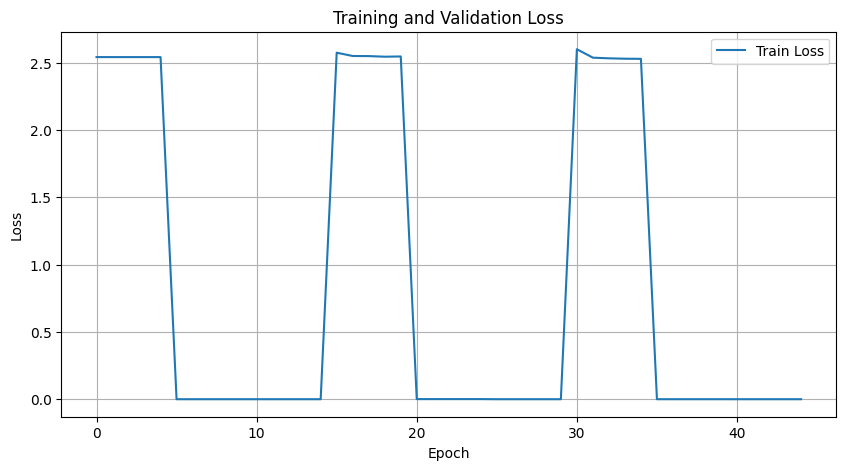


Recommendation system training and evaluation complete!


In [ ]:
from faker import Faker  # For fake user_id generation
import logging
import random
import argparse
import pandas as pd
import numpy as np
import torch

def parse_args(argv = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description="Sentiment classification with fake user IDs and text features"
    )
    parser.add_argument("--input", required=True, help="Path to input CSV file with columns: polarity,title,text")
    parser.add_argument("--n_users", type=int, default=1000, help="Number of unique fake users to simulate")
    parser.add_argument("--test_size", type=float, default=0.2, help="Test set fraction")
    parser.add_argument("--random_seed", type=int, default=42, help="Random seed for reproducibility")
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size for PyTorch DataLoader")
    parser.add_argument("--epochs", type=int, default=5, help="Number of training epochs")
    return parser.parse_args(argv)

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

# Main function to run the complete pipeline
def main():
    print("Starting User Cold Start Recommendation System")

    # 1. Download and load the dataset
    dataset_path = download_and_extract_dataset()
    # Create an argument parser
    parser = argparse.ArgumentParser(description="User Cold Start Recommendation System")
    # Define the input argument
    parser.add_argument("--input", required=True, help="Path to the input dataset")
    parser.add_argument("--n_users", type=int, default=500, help="Number of unique fake users to simulate")
    parser.add_argument("--epochs", type=int, default=3, help="Number of training epochs")
    parser.add_argument("--random_seed", type=int, default=3, help="seeder for randomization")
    # Parse the arguments
    args = parser.parse_args([
        "--input", dataset_path,
        "--n_users", "500",
        "--epochs", "3",
        "--random_seed", "42"
    ])
    setup_logging()
    np.random.seed(args.random_seed)
    random.seed(args.random_seed)
    torch.manual_seed(args.random_seed)

    # df = load_and_prepare(args.input, args.n_users, args.random_seed)

    df, user_id_map, item_id_map, text_features = load_data(dataset_path)

    # 2. Create cold start scenario
    train_df, test_df, cold_user_mask, cold_users = create_cold_start_scenario(df)

    # Print some statistics
    print("\nDataset Statistics:")
    print(f"Total users: {len(user_id_map)}")
    print(f"Total items: {len(item_id_map)}")
    print(f"Total interactions: {len(df)}")
    print(f"Cold start users: {sum(cold_user_mask)} ({sum(cold_user_mask)/len(user_id_map):.1%})")

    # 3. Initialize models
    n_users = len(user_id_map)
    n_items = len(item_id_map)

    print("\nInitializing Self-Paced Matrix Factorization model...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    spmf = SelfPacedMatrixFactorization(
        n_users=n_users,
        n_items=n_items,
        n_factors=30,
        lambda_start=0.1,
        lambda_end=5.0,
        lambda_steps=3,
        learning_rate=0.01,
        weight_decay=0.001,
        batch_size=256,
        device=device
    )

    # 4. Initialize semi-supervised recommender
    print("\nInitializing Semi-supervised Recommender...")
    semi_supervised = SemiSupervisedRecommender(
        base_model=spmf,
        n_users=n_users,
        n_items=n_items,
        confidence_threshold=0.8
    )

    # 5. Train semi-supervised model
    print("\nTraining semi-supervised model...")
    semi_supervised.train_semi_supervised(
        train_df=train_df,
        test_df=test_df,
        cold_users=cold_users,
        epochs_per_stage=5,
        total_stages=3
    )

    # 6. Evaluate model performance
    print("\nEvaluating model performance...")

    # Overall performance
    overall_rmse, overall_mae = semi_supervised.evaluate(test_df)
    print(f"Overall Test RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

    # Performance on cold users
    cold_test_df = test_df[test_df['user_idx'].isin(cold_users)]
    if len(cold_test_df) > 0:
        cold_rmse, cold_mae = semi_supervised.evaluate(cold_test_df)
        print(f"Cold Users Test RMSE: {cold_rmse:.4f}, MAE: {cold_mae:.4f}")

    # 7. Generate recommendations
    print("\nGenerating recommendations for sample users...")

    # Sample a few users for recommendation examples
    sample_users = np.random.choice(cold_users, min(5, len(cold_users)), replace=False)

    user_recommendations = {}
    for user_idx in sample_users:
        recommendations = semi_supervised.get_recommendations(user_idx, n_recommendations=10)
        user_recommendations[user_idx] = recommendations

        # Map back to original user/item IDs for display
        rev_user_id_map = {v: k for k, v in user_id_map.items()}
        rev_item_id_map = {v: k for k, v in item_id_map.items()}

        user_id = rev_user_id_map.get(user_idx, f"User_{user_idx}")
        print(f"\nTop 10 recommendations for user {user_id}:")

        for i, (item_idx, score) in enumerate(recommendations, 1):
            item_id = rev_item_id_map.get(item_idx, f"Item_{item_idx}")
            print(f"{i}. Item {item_id} - Score: {score:.2f}")

    # 8. Analyze time-to-quality
    print("\nAnalyzing time-to-quality for cold users...")

    # Create a fresh model for this analysis
    fresh_spmf = SelfPacedMatrixFactorization(
        n_users=n_users,
        n_items=n_items,
        n_factors=30,
        lambda_start=0.1,
        lambda_end=5.0,
        lambda_steps=3,
        device=device
    )

    fresh_semi = SemiSupervisedRecommender(
        base_model=fresh_spmf,
        n_users=n_users,
        n_items=n_items
    )

    ttq_results = evaluate_time_to_quality(
        model=fresh_semi,
        train_df=train_df,
        test_df=test_df,
        cold_users=cold_users,
        epochs=[1, 4, 5, 10]  # Smaller for demonstration
    )

    print("\nTime-to-quality results:")
    print(ttq_results)

    # 9. Plot loss history
    print("\nPlotting loss history...")
    spmf.plot_loss_history()

    print("\nRecommendation system training and evaluation complete!")

    return {
        "model": semi_supervised,
        "metrics": {
            "overall_rmse": overall_rmse,
            "overall_mae": overall_mae,
            "cold_rmse": cold_rmse if len(cold_test_df) > 0 else None,
            "cold_mae": cold_mae if len(cold_test_df) > 0 else None
        },
        "time_to_quality": ttq_results
    }

# Entry point for the script
if __name__ == "__main__":
    main()